# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
from keras.layers import Conv2D,MaxPooling2D
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size =20 #experiment with the batch size

In [4]:
len(train_doc),len(val_doc)

(663, 100)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(80,80)).astype(np.float32)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Model 1

### This is 3D CNN architecture to process the video frames. It has 2 Convlolution layers with 16 and 32 kernels of (3x3x3) and image size 80x80

In [7]:


#write your model here
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2025-03-31 16:16:19.660783: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-31 16:16:19.660857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22666 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:40:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 16)    1312      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
# Define model name and create directory if it doesn't exist
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the filepath for saving the model
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Define the ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# List of callbacks
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20


2025-03-31 16:17:03.922054: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6046 - categorical_accuracy: 0.3794Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-3116_16_10.181665/model-00001-1.60456-0.37941-1.71951-0.21000.h5
34/34 [==============================] - 70s 2s/step - loss: 1.6046 - categorical_accuracy: 0.3794 - val_loss: 1.7195 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1619 - categorical_accuracy: 0.5426
Epoch 00002: saving model to model_init_2025-03-3116_16_10.181665/model-00002-1.16189-0.54265-2.41399-0.19000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.1619 - categorical_accuracy: 0.5426 - val_loss: 2.4140 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9815 - categorical_accuracy: 0.6353
Epoch 00003: saving model to model_init_2025-03-3116_16_10.181665/mode

<Figure size 720x720 with 0 Axes>

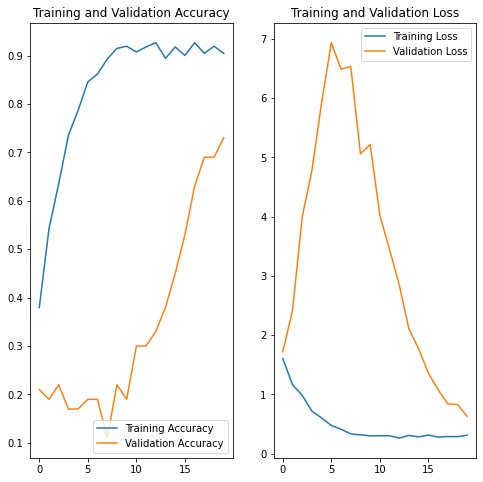

In [14]:
plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### the model uses 2,477,669 Trainable params and has  90.4% as accuracy on train set and 73% on validation set. Let see if we can improve the acuraccy by using convolution layer of 32 and 64filters and increasing the epoch to 25

# Model 2

### This is 3D CNN architecture to process the video frames. It has 2 Convlolution layers with 32 and 64 kernels of (3x3x3) and image size 80x80

In [15]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [16]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_2 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_4 (Batc  (None, 13, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 40, 40, 64)     55360     
                                                                 
 activation_3 (Activation)   (None, 6, 40, 40, 64)    

In [17]:
batch_size = 20
num_epochs = 25

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6965 - categorical_accuracy: 0.3721Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-3116_16_10.181665/model-00001-1.69646-0.37206-1.66153-0.19000.h5
34/34 [==============================] - 71s 2s/step - loss: 1.6965 - categorical_accuracy: 0.3721 - val_loss: 1.6615 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1779 - categorical_accuracy: 0.5338
Epoch 00002: saving model to model_init_2025-03-3116_16_10.181665/model-00002-1.17787-0.53382-2.28259-0.27000.h5
34/34 [==============================] - 67s 2s/step - loss: 1.1779 - categorical_accuracy: 0.5338 - val_loss: 2.2826 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0142 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

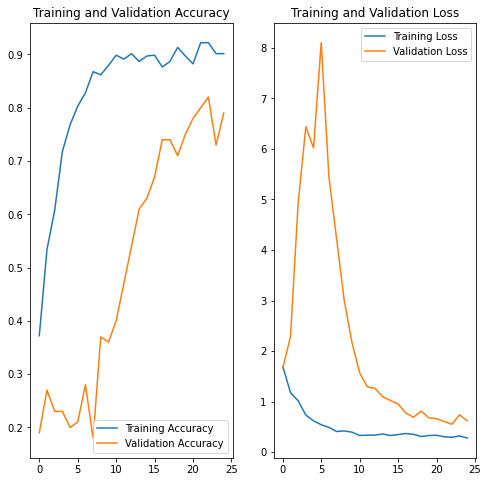

In [21]:
plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### the model uses 9,897,669 Trainable params and has  90.1% as accuracy on train set and 79% on validation set. we can see the resultant validation acuracy has increased 

# Model 3

### This is 3D CNN architecture to process the video frames. It has 2 Convlolution layers with 16 and 32 kernels of (3x3x3).Using Image size as 120x120

In [24]:
batch_size=20

In [25]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[2,4,6,8,10,12,14,16,18,20,22,24,26] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(120,120)).astype(np.float32)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,120,120,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(120,120)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels


In [26]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
batch_size=20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [28]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',
         input_shape=(13,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [29]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 13, 120, 120, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 13, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 13, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 6, 60, 60, 32)     13856     
                                                                 
 activation_7 (Activation)   (None, 6, 60, 60, 32)    

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5570 - categorical_accuracy: 0.4353Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-3116_16_10.181665/model-00001-1.55700-0.43529-1.67984-0.26000.h5
34/34 [==============================] - 70s 2s/step - loss: 1.5570 - categorical_accuracy: 0.4353 - val_loss: 1.6798 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0764 - categorical_accuracy: 0.5676
Epoch 00002: saving model to model_init_2025-03-3116_16_10.181665/model-00002-1.07638-0.56765-2.23228-0.16000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.0764 - categorical_accuracy: 0.5676 - val_loss: 2.2323 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8733 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

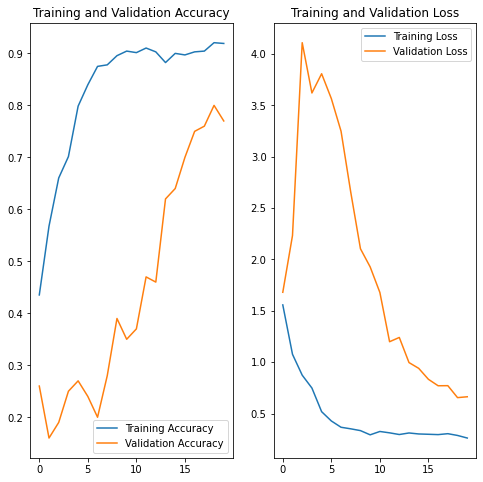

In [33]:
plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### the model uses 5,549,669 Trainable params and has  91.9% as accuracy on train set and 77% on validation set. 

# Model4

### This is 3D CNN + LSTM architecture to process the video frames. It has 2 Convlolution layers with 32 and 64 kernels of (3x3x3) and a LSTM layer with 128 neurons.Using Image size as 80x80

In [34]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)




# training sequences = 663
# validation sequences = 100


In [35]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[2,4,6,8,10,12,14,16,18,20,22,24,26] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(80,80)).astype(np.float32)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels


In [36]:

model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [37]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_8 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_16 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 6, 40, 40, 64)     55360     
                                                                 
 activation_9 (Activation)   (None, 6, 40, 40, 64)    

In [38]:
batch_size = 20
num_epochs = 25

In [39]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9585 - categorical_accuracy: 0.2588Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-3116_16_10.181665/model-00001-1.95850-0.25882-1.69530-0.17000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.9585 - categorical_accuracy: 0.2588 - val_loss: 1.6953 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5847 - categorical_accuracy: 0.3809
Epoch 00002: saving model to model_init_2025-03-3116_16_10.181665/model-00002-1.58466-0.38088-1.73925-0.15000.h5
34/34 [==============================] - 70s 2s/step - loss: 1.5847 - categorical_accuracy: 0.3809 - val_loss: 1.7392 - val_categorical_accuracy: 0.1500 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3951 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

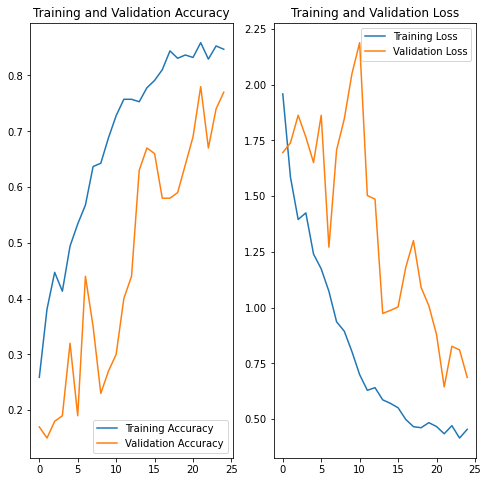

In [42]:
plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### the model uses 13,240,133 Trainable params and has  84.7% as accuracy on train set and 77% on validation set. 

# Model 5

### This is 2D CNN + LSTM architecture to process the video frames. It has 4 Convlolution layers with 16,32,64 and 128 kernels of (3x3) and a LSTM layer with 128 neurons.Using Image size as 80x80

In [43]:
from keras.layers import Conv2D,MaxPooling2D

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(13, 80,80,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [44]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 13, 80, 80, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 13, 80, 80, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 13, 40, 40, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 13, 40, 40, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 13, 40, 40, 32)  

In [46]:
batch_size = 20
num_epochs = 25

In [48]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [49]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [50]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0371 - categorical_accuracy: 0.2765Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-3116_16_10.181665/model-00001-2.03713-0.27647-1.66164-0.18000.h5
34/34 [==============================] - 73s 2s/step - loss: 2.0371 - categorical_accuracy: 0.2765 - val_loss: 1.6616 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.5840 - categorical_accuracy: 0.3712
Epoch 00002: saving model to model_init_2025-03-3116_16_10.181665/model-00002-1.56481-0.37941-1.76462-0.17000.h5
34/34 [==============================] - 68s 2s/step - loss: 1.5648 - categorical_accuracy: 0.3794 - val_loss: 1.7646 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.5331 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

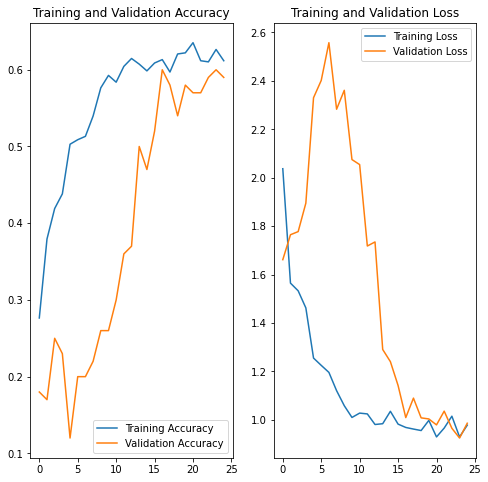

In [51]:
plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### the model uses 1,811,077 Trainable params and has  61% as accuracy on train set and 59% on validation set. Model is under performing

# Model 6


#### This is 2D CNN + LSTM architecture to process the video frames. It has 3 Convlolution layers with 32,64 and 128 kernels of (3x3) and a LSTM layer with 128 neurons.Using Image size as 80x80.Increasing epoch to 30

In [52]:
from keras.layers import Conv2D,MaxPooling2D

model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'),
            input_shape=(13, 80,80,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(5,activation='softmax'))

In [53]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 13, 80, 80, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 13, 80, 80, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 13, 40, 40, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 13, 40, 40, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 13, 40, 40, 64)  

In [54]:
batch_size = 30
num_epochs = 30

In [55]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [56]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [57]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.2289 - categorical_accuracy: 0.2580Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2025-03-3116_16_10.181665/model-00001-2.22890-0.25797-1.63288-0.17500.h5
23/23 [==============================] - 78s 3s/step - loss: 2.2289 - categorical_accuracy: 0.2580 - val_loss: 1.6329 - val_categorical_accuracy: 0.1750 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.8611 - categorical_accuracy: 0.3333
Epoch 00002: saving model to model_init_2025-03-3116_16_10.181665/model-00002-1.86107-0.33333-1.63253-0.16667.h5
23/23 [==============================] - 71s 3s/step - loss: 1.8611 - categorical_accuracy: 0.3333 - val_loss: 1.6325 - val_categorical_accuracy: 0.1667 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.5419 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

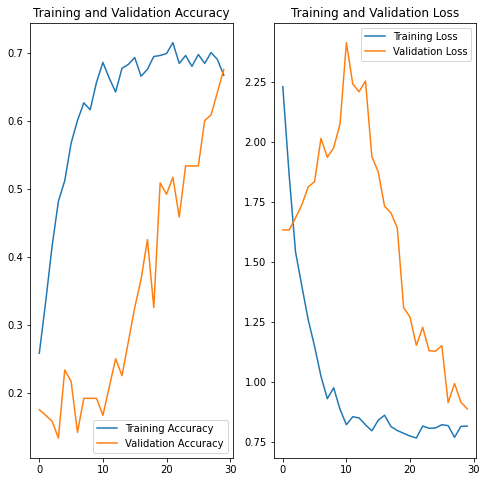

In [58]:
plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### the model uses 6,722,053 Trainable params and has  66.7% as accuracy on train set and 67% on validation set.accuracy has slightly improve d but  Model is under performing

In [ ]:
#  Model    Trainable Params  Train accuracy   Val accuracy
#   1         2,477,669         90.4%              73%
#   2         9,897,669         90.1%              79%
#   3         5,549,669         91.9%              77%
#   4        13,240,133         84.7%              77%
#   5         1,811,077          61%               59%
#   6         6,722,053         66.7%              67%